<a href="https://colab.research.google.com/github/mattcvincent/MachineLearningBook/blob/main/chapters/Machine_Learning_Book_Ch_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topics

1.   Intro to algorithms for classification 
  -  Logistic regression, SVM, decision tress, k-nearest
2.   Examples w/ scikit-learn ML library
3.   Strengths/weaknesses of classifiers w/ linear and nonlinear decision boundaries.

In practice, it is always recommended that you compare the performance of at least a handful of different learning algorithms to select the best model for the particular problem; these may differ in the number of features or examples, the amount of noise in a dataset, and whether the classes are linearly separable.

# Steps

5 main steps for training a supervised ML algorithm:
* Selecting features and collecting labeled training examples 
* Choosing a performance metric Choosing a learning algorithm and training a model
* Evaluating the performance of the model * Changing the settings of the algorithm and tuning the model.

In [2]:
from sklearn import datasets
import numpy as np
iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target
print('Class labels:', np.unique(y))

Class labels: [0 1 2]


In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))


Labels counts in y: [50 50 50]
Labels counts in y_train: [35 35 35]
Labels counts in y_test: [15 15 15]


In [4]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [5]:
from sklearn.linear_model import Perceptron
# eta0 is learning rate
# if too large, overshoot the global loss minimum
# if too small, requires more epochs until convergence, thus slower learning
ppn = Perceptron(eta0=0.1, random_state=1)
ppn.fit(X_train_std, y_train)

y_pred = ppn.predict(X_test_std)
print('Misclassified examples: %d' % (y_test != y_pred).sum())

Misclassified examples: 1


In [6]:
# Instead of misclassification error, ML practitionners 
# report the classification accuracy of a model.
# This is a matter of preference
from sklearn.metrics import accuracy_score
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
Accuracy: 0.978

Accuracy: 0.978


In [7]:
print('Accuracy: %.3f' % ppn.score(X_test_std, y_test))

Accuracy: 0.978


In [8]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
def plot_decision_regions(X, y, classifier, test_idx=None,
                          resolution=0.02):
    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=f'Class {cl}',
                    edgecolor='black')
    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]
        
        plt.scatter(X_test[:, 0], X_test[:, 1],
                    c='none', edgecolor='black', alpha=1.0,
                    linewidth=1, marker='o',
                    s=100, label='Test set')

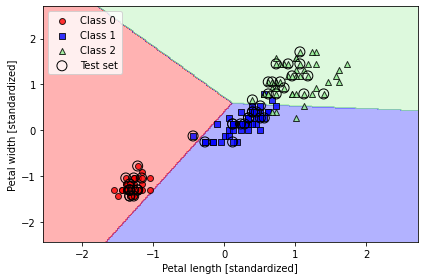

In [9]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X=X_combined_std,
                      y=y_combined,
                      classifier=ppn,
                      test_idx=range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

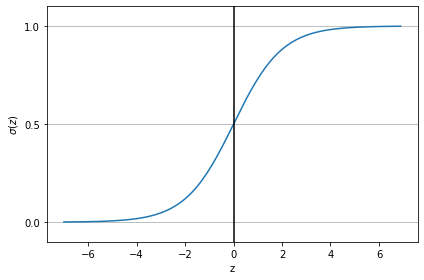

In [10]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))
z = np.arange(-7, 7, 0.1)
sigma_z = sigmoid(z)
plt.plot(z, sigma_z)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\sigma (z)$')
# y axis ticks and gridline
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

In [11]:
class LogisticRegressionGD:
    """Gradient descent-based logistic regression classifier.
    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.
    Attributes
    -----------
    w_ : 1d-array
    Weights after training.
    b_ : Scalar
      Bias unit after fitting.
    losses_ : list
      Mean squared error loss function values in each epoch.
    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
    def fit(self, X, y):
        """ Fit training data.
        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the 
          number of examples and n_features is the 
          number of features.
        y : array-like, shape = [n_examples]
        Target values.
        Returns
        -------
        self : Instance of LogisticRegressionGD
        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.float_(0.)
        self.losses_ = []
        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta * 2.0 * errors.mean()
            loss = (-y.dot(np.log(output))
                   - ((1 - y).dot(np.log(1 - output)))
                   / X.shape[0])
            self.losses_.append(loss)
        return self
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_
    def activation(self, z):
        """Compute logistic sigmoid activation"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))
    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

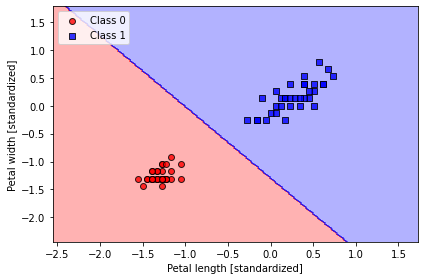

In [12]:
X_train_01_subset = X_train_std[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]
lrgd = LogisticRegressionGD(eta=0.3,
                            n_iter=1000,
                            random_state=1)
lrgd.fit(X_train_01_subset,
         y_train_01_subset)
plot_decision_regions(X=X_train_01_subset,
                      y=y_train_01_subset,
                      classifier=lrgd)
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Default Model
For minimizing convex loss functions, such as the logistic regression loss, it is recommended to use more advanced approaches than regular stochastic gradient descent (SGD). In fact, scikit-learn implements a whole range of such optimization algorithms, which can be specified via the solver parameter, namely, 'newton-cg', 'lbfgs', 'liblinear', 'sag', and 'saga'.

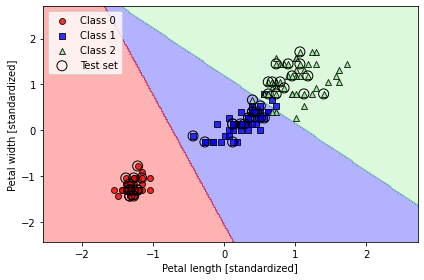

In [13]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=100.0, solver='lbfgs',
                        multi_class='ovr')
lr.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std,
                      y_combined,
                      classifier=lr,
                      test_idx=range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# SGD
For minimizing convex loss functions, such as the logistic regression loss, it is recommended to use more advanced approaches than regular stochastic gradient descent (SGD). In fact, scikit-learn implements a whole range of such optimization algorithms, which can be specified via the solver parameter, namely, 'newton-cg', 'lbfgs', 'liblinear', 'sag', and 'saga'.


In [14]:
lr.predict_proba(X_test_std[:3, :])

array([[3.81527885e-09, 1.44792866e-01, 8.55207131e-01],
       [8.34020679e-01, 1.65979321e-01, 3.25737138e-13],
       [8.48831425e-01, 1.51168575e-01, 2.62277619e-14]])

In [15]:
lr.predict_proba(X_test_std[:3, :]).sum(axis=1)

array([1., 1., 1.])

In [16]:
lr.predict_proba(X_test_std[:3, :])

array([[3.81527885e-09, 1.44792866e-01, 8.55207131e-01],
       [8.34020679e-01, 1.65979321e-01, 3.25737138e-13],
       [8.48831425e-01, 1.51168575e-01, 2.62277619e-14]])

In [17]:
lr.predict(X_test_std[0, :].reshape(1, -1))

array([2])

# Tackling overfitting via regularization 
Overfitting is a common problem in machine learning, where a model performs well on training data but does not generalize well to unseen data (test data). If a model suffers from overfitting, we also say that the model has a high variance, which can be caused by having too many parameters, leading to a model that is too complex given the underlying data. Similarly, our model can also suffer from underfitting (high bias), which means that our model is not complex enough to capture the pattern in the training data well and therefore also suffers from low performance on unseen data.

“high variance” is proportional to overfitting and “high bias” is proportional to underfitting.

One way of finding a good bias-variance tradeoff is to tune the complexity of the model via regularization. Regularization is a very useful method for handling collinearity (high correlation among features), filtering out noise from data, and eventually preventing overfitting.

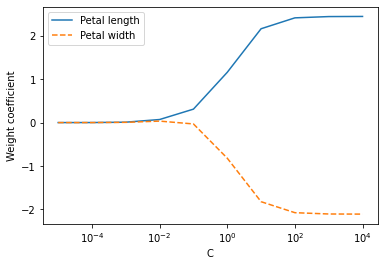

In [18]:
weights, params = [], []
for c in np.arange(-5, 5):
    lr = LogisticRegression(C=10.**c,
                            multi_class='ovr')
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10.**c)
weights = np.array(weights)
plt.plot(params, weights[:, 0],
         label='Petal length')
plt.plot(params, weights[:, 1], linestyle='--',
         label='Petal width')
plt.ylabel('Weight coefficient')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
plt.show()

# Support vector machine (SVM)
 

*   Using the perceptron algorithm, we minimized misclassification errors
*   However, in SVMs, our optimization objective is to maximize the margin
* The margin is defined as the distance between the separating hyperplane (decision boundary) and the training examples closest to the hyperplane (the support vectors).

Below, let’s train an SVM model to classify the different flowers in our Iris dataset:

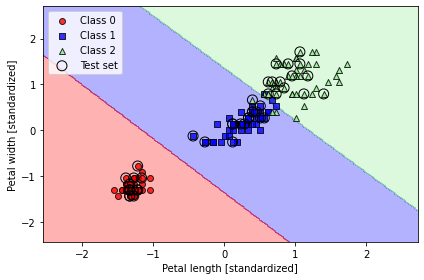

In [19]:
from sklearn.svm import SVC
svm = SVC(kernel='linear', C=1.0, random_state=1)
svm.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std,
                      y_combined,
                      classifier=svm,
                      test_idx=range(105, 150))
plt.xlabel('Petal length [standardized]')
plt.ylabel('Petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()


# Linear logistic regression and linear SVM

* They often yield very similar results
* Logistic regression tries to maximize the conditional likelihoods of the training data
  *  which makes it more prone to outliers than SVMs
* SVMs mostly care about the points that are closest to the decision boundary (support vectors). 
* Logistic regression has the advantage of being a simpler model and can be implemented more easily, and is mathematically easier to explain